In [ ]:
from google.colab import drive
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import time
import copy
from tensorflow.keras.callbacks import ReduceLROnPlateau

# PyTorch replacements
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms



# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [16]:
CONFIG = {
    # --- Architecture ---
    "model": "ResNet50",
    "strategy": "feature_extraction",
    "dataset_path": "/content/drive/MyDrive/Inter IIT/Updated_data",

    # --- Crucial Parameters ---
    "epochs": 1,               # 15 was not enough to converge. We need 20.
    "fine_tune_layers": "all",  # MANDATORY for satellite data domain shift.
    "batch_size": 128,          # Keep this. High batch size stabilizes fine-tuning.
    "learning_rate": 1e-08,  # (5e-6). Increased from 1e-6. We need more plasticity.

    # --- Checkpoint Logic ---
    "load_checkpoint": "yes",
    # LOAD MODEL 4 (The 93% version)
    "checkpoint_load_path": "/content/drive/MyDrive/Inter IIT/Data/Checkpoint_trained_models/ResNet:50_mach-5(ongoing)/current_training_model6.pt",
    "save_path": "/content/drive/MyDrive/Inter IIT/Data/Checkpoint_trained_models/ResNet:50_mach-5(ongoing)/current_training_model69.pt",

    # --- Regularization (Tweaked) ---
    "val_split": 0.1,
    "dropout_rate": 0.3,        # Keep this. Good for fully connected layers.
    "l2_reg": 1e-5,             # REDUCED from 5e-5. The previous value was suffocating the weights.

    # --- Augmentation (Keep "Mild") ---
    "use_augmentation": False,
    "rotation_range": 0.1,      # Keep 10% rotation. Safe for urban grids/crops.
    "zoom_range": 0.05,         # Keep 5% zoom. Safe for resolution.
    "flip_horizontal": True,

    # --- Controls ---
    "Training Control": True,
    "early_stopping_patience": 8,
    "lr_reduction_patience": 4, # If it stalls for 4 epochs, drop LR.
    "lr_reduction_factor": 0.2,
    "min_lr": 1e-8,
}

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import os

def count_nested_images(directory_path):
    image_count = 0
    image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp')

    if not os.path.isdir(directory_path):
        print(f"Error: Directory not found at '{directory_path}'")
        return 0

    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith(image_extensions):
                image_count += 1
    return image_count

# Example usage:
directory_to_scan = '/content/drive/MyDrive/Inter IIT/Data/SARV2_resized/sar_quads'
total_images = count_nested_images(directory_to_scan)
print(f"Total number of nested images in '{directory_to_scan}': {total_images}")

Total number of nested images in '/content/drive/MyDrive/Inter IIT/Data/SARV2_resized/sar_quads': 6802


In [12]:
import os
from PIL import Image
import numpy as np

def load_cifar_cats_dogs_recursive(data_dir, val_split=0.2, samples_per_class=None):
    # MANUALLY EDIT THIS VECTOR TO CHOOSE YOUR CLASSES
    target_classes = [
        "false_color",
        # "ndvi",
        "SARV2_resized",
        # "swir",
        "true_color",
        # "urban",
        # "geology",
        # "nir_boost",
    ]

    print(f"Looking strictly for folders: {target_classes}")

    x_data = []
    y_data = []
    valid_classes = []

    # Iterate strictly through your manual list
    for class_idx, class_name in enumerate(target_classes):
        class_path = os.path.join(data_dir, class_name)

        # Check if the folder actually exists
        if not os.path.isdir(class_path):
            print(f"CRITICAL WARNING: Folder '{class_name}' not found in {data_dir}. Skipping.")
            continue

        valid_classes.append(class_name)
        img_count = 0

        # Walk through subdirectories
        for root, _, files in os.walk(class_path):
            for img_file in files:
                if samples_per_class is not None and img_count >= samples_per_class:
                    break

                if img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                    try:
                        img_path = os.path.join(root, img_file)
                        img = Image.open(img_path).convert('RGB')
                        img = img.resize((256, 256)) # ResNet standard
                        img_array = np.array(img, dtype='uint8')

                        # (H, W, C) -> (C, H, W)
                        img_array = np.transpose(img_array, (2, 0, 1))

                        x_data.append(img_array)
                        # Use the index from target_classes as the label
                        y_data.append(class_idx)
                        img_count += 1
                    except Exception as e:
                        print(f"Error loading {img_file}: {e}")

            if samples_per_class is not None and img_count >= samples_per_class:
                break

        print(f"Class '{class_name}' (Label {class_idx}): Loaded {img_count} images")

    x_data = np.array(x_data)
    y_data = np.array(y_data)

    if len(x_data) == 0:
        print("No data loaded. Check your folder names.")
        return None

    # Shuffle
    shuffle_idx = np.random.permutation(len(x_data))
    x_data = x_data[shuffle_idx]
    y_data = y_data[shuffle_idx]

    # Split: Train/Val (80%) vs Test (20%)
    test_split_idx = int(0.1 * len(x_data))
    x_train_val = x_data[:test_split_idx]
    y_train_val = y_data[:test_split_idx]
    x_test = x_data[test_split_idx:]
    y_test = y_data[test_split_idx:]

    # Split: Train vs Val
    split_idx = int((1 - val_split) * len(x_train_val))
    x_val, y_val = x_train_val[split_idx:], y_train_val[split_idx:]
    x_train, y_train = x_train_val[:split_idx], y_train_val[:split_idx]

    print(f"Final Counts -> Train: {len(x_train)}, Val: {len(x_val)}, Test: {len(x_test)}")

    return (x_train, y_train), (x_val, y_val), (x_test, y_test), valid_classes

In [18]:
### DATA LOADER ###
(x_train, y_train), (x_val, y_val), (x_test, y_test), class_dirs = load_cifar_cats_dogs_recursive(CONFIG['dataset_path'], val_split=CONFIG['val_split'], samples_per_class=4000)

Looking strictly for folders: ['false_color', 'SARV2_resized', 'true_color']
Class 'false_color' (Label 0): Loaded 4000 images
Class 'SARV2_resized' (Label 1): Loaded 4000 images
Class 'true_color' (Label 2): Loaded 4000 images
Final Counts -> Train: 1080, Val: 120, Test: 10800


In [19]:
#### Do this when changing dataset, so do after 'DATA LOADER' ###
import numpy as np
import os

cache_path = "/content/drive/MyDrive/Inter IIT/Data/DONT_TOUCH_3new_bands_12k_cached.npz"

np.savez_compressed(
    cache_path,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    x_test=x_test,
    y_test=y_test,
    class_dirs=np.array(class_dirs)
)

print("Cached dataset to:", cache_path)

Cached dataset to: /content/drive/MyDrive/Inter IIT/Data/DONT_TOUCH_3new_bands_20k_cached.npz


In [ ]:
### Directly loading dataset from .npz file cached ###
import numpy as np

cache_path = "/content/drive/MyDrive/Inter IIT/Data/DONT_TOUCH_6_bands_cached.npz"

data = np.load(cache_path, allow_pickle=True)

x_train = data["x_train"]
y_train = data["y_train"]
x_val   = data["x_val"]
y_val   = data["y_val"]
x_test  = data["x_test"]
y_test  = data["y_test"]
class_dirs = data["class_dirs"].tolist()  # back to Python list if needed
# Run this once immediately after loading x_train, x_val, x_test
# Convert (N, H, W, C) -> (N, C, H, W) globally
x_train = x_train.transpose(0, 3, 1, 2)
x_val = x_val.transpose(0, 3, 1, 2)
x_test = x_test.transpose(0, 3, 1, 2)
print(x_train.shape, x_val.shape, x_test.shape)
print(class_dirs)

(10800, 256, 3, 256) (1200, 256, 3, 256) (3000, 256, 3, 256)
['false_color', 'ndvi', 'SARV2_resized', 'swir', 'true_color', 'urban']


In [20]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import models

# --- Robust Dataset Class ---
# --- Robust Dataset Class ---
class ArrayDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # Load data
        img = self.x[idx]
        label = torch.tensor(self.y[idx], dtype=torch.long)

        # Ensure Tensor & Float
        if not isinstance(img, torch.Tensor):
            img = torch.tensor(img, dtype=torch.float32)
        else:
            img = img.float()

        # --- SMART SHAPE CHECK ---
        # Fixes your runtime error by finding where the '3' (channel) dimension is
        if img.ndim == 3:
            if img.shape[-1] == 3:         # Case (H, W, C) -> Permute to (C, H, W)
                img = img.permute(2, 0, 1)
            elif img.shape[1] == 3:        # Case (H, C, W) -> Permute to (C, H, W) [FIXES YOUR ERROR]
                img = img.permute(1, 0, 2)

        # Scale [0, 1] (Assuming input is 0-255)
        if img.max() > 1.0:
            img = img / 255.0

        # Apply Augmentations
        if self.transform:
            img = self.transform(img)

        # Normalize (Requires 3, H, W)
        norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        img = norm(img)

        return img, label

def create_model(config, num_classes):
    print(f"Initializing {config['model']}...")

    if config['model'] == "ResNet50":
        base_model = models.resnet50(weights='IMAGENET1K_V2')
        for param in base_model.parameters():
            param.requires_grad = False

        in_features = base_model.fc.in_features
        base_model.fc = nn.Sequential(
            nn.Linear(in_features, 512),   # Compress to 512
            nn.BatchNorm1d(512),           # Stabilize training
            nn.ReLU(),
            nn.Dropout(config['dropout_rate']),
            nn.Linear(512, num_classes)    # Final projection
        )

    elif config['model'] == "MobileNetV2":
        base_model = models.mobilenet_v2(weights='IMAGENET1K_V2')
        for param in base_model.parameters():
            param.requires_grad = False

        in_features = base_model.last_channel
        base_model.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(config['dropout_rate']),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(config['dropout_rate'] * 0.8),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(config['dropout_rate'] * 0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(config['dropout_rate'] * 0.5),
            nn.Linear(64, num_classes)
        )

    elif config['model'] == "VGG16":
        base_model = models.vgg16(weights='IMAGENET1K_V1')
        for param in base_model.parameters():
            param.requires_grad = False

        in_features = base_model.classifier[0].in_features
        base_model.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(config['dropout_rate']),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(config['dropout_rate'] * 0.8),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(config['dropout_rate'] * 0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(config['dropout_rate'] * 0.5),
            nn.Linear(64, num_classes)
        )

    elif config['model'] == "MobileNetV3":
        base_model = models.mobilenet_v3_large(weights='IMAGENET1K_V1')
        for param in base_model.parameters():
            param.requires_grad = False

        in_features = base_model.classifier[0].in_features
        base_model.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(config['dropout_rate']),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(config['dropout_rate'] * 0.8),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(config['dropout_rate'] * 0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(config['dropout_rate'] * 0.5),
            nn.Linear(64, num_classes)
        )

    else:
        raise ValueError(f"Model {config['model']} not supported in create_model")

    return base_model.to(device, memory_format=torch.channels_last)
# --- Summary Helper Function ---
def print_model_summary(model):
    print("\n" + "="*80)
    print(f"{'Layer (type)':<30} {'Output Shape':<25} {'Param #':<15}")
    print("="*80)

    total_params = 0
    trainable_params = 0

    # Iterate through top-level modules to mimic Keras summary
    # (Printing every single weight tensor would be too long for ResNet)
    for name, module in model.named_children():
        num_params = sum(p.numel() for p in module.parameters())
        if num_params > 0:
            # Check if any param in module is trainable
            is_trainable = any(p.requires_grad for p in module.parameters())
            total_params += num_params
            if is_trainable:
                trainable_params += num_params

            print(f"{name:<30} {'[Batch, ...]' :<25} {num_params:<15,}")

    # Check for parameters directly in the parent model (like custom heads)
    parent_params = sum(p.numel() for p in model.parameters(recurse=False))
    if parent_params > 0:
        total_params += parent_params
        if any(p.requires_grad for p in model.parameters(recurse=False)):
            trainable_params += parent_params
        print(f"{'Top Level Params':<30} {'-':<25} {parent_params:<15,}")

    print("="*80)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {trainable_params:,}")
    print(f"Non-trainable params: {total_params - trainable_params:,}")
    print(f"Model size (est.): {total_params * 4 / (1024**2):.2f} MB")
    print("="*80 + "\n")

KeyboardInterrupt: 

In [ ]:
import torch.optim as optim
from torch.amp import GradScaler, autocast
import os

# --- Hardware Settings ---
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.backends.cudnn.benchmark = True
os.environ["TORCH_LOGS"] = "-all"

# --- Setup Model ---
model = create_model(CONFIG, len(class_dirs))

# --- Checkpoint Loading Logic ---
if CONFIG['load_checkpoint'] == 'yes':
    load_path = CONFIG['checkpoint_load_path']
    print(f"Loading weights from {load_path}...")
    try:
        model.load_state_dict(torch.load(load_path, map_location=device))
        print("Weights loaded successfully.")
    except Exception as e:
        print(f"Error loading weights: {e}")
        print("Starting from ImageNet weights instead.")
else:
    print("Starting training from scratch (ImageNet weights).")

# OPTIMIZATION: Channels Last Memory Format
model = model.to(device, memory_format=torch.channels_last)

# Unfreeze Logic (Applied BEFORE compile)
# --- UNFREEZING LOGIC (Using fine_tune_layers) ---

if CONFIG["strategy"] == "fine_tuning":
    n_layers = CONFIG["fine_tune_layers"]
    print(f"\n--- Configuring Fine-Tuning (Unfreezing top {n_layers} layer groups) ---")

    # 1. Freeze EVERYTHING first
    for param in model.parameters():
        param.requires_grad = False
    if CONFIG["fine_tune_layers"] == "all":
        print("-> Unfreezing ENTIRE model (including Stem) for deep adaptation.")
        for param in model.parameters():
            param.requires_grad = True
    else:
      # 2. Always unfreeze the Head
      # ResNet uses .fc, MobileNet/VGG use .classifier
      if hasattr(model, 'fc'):
          for param in model.fc.parameters(): param.requires_grad = True
      elif hasattr(model, 'classifier'):
          for param in model.classifier.parameters(): param.requires_grad = True
      print("-> Head (FC/Classifier) unfrozen.")

      # 3. Unfreeze based on integer parameter
      # Maps integer 1-4 to ResNet blocks (layer4=top, layer1=bottom)
      if hasattr(model, 'layer4') and n_layers >= 1:
          for param in model.layer4.parameters(): param.requires_grad = True
          print("-> Layer 4 (Objects) unfrozen.")

      if hasattr(model, 'layer3') and n_layers >= 2:
          for param in model.layer3.parameters(): param.requires_grad = True
          print("-> Layer 3 (Parts/Textures) unfrozen.")

      if hasattr(model, 'layer2') and n_layers >= 3:
          for param in model.layer2.parameters(): param.requires_grad = True
          print("-> Layer 2 (Patterns) unfrozen.")

      if hasattr(model, 'layer1') and n_layers >= 4:
          for param in model.layer1.parameters(): param.requires_grad = True
          print("-> Layer 1 (Basic Features) unfrozen.")


# Print summary to verify trainable vs frozen params
print_model_summary(model)
# OPTIMIZATION: Torch Compile
print("Compiling model graph...")
model = torch.compile(model)

# --- Data Loaders ---
train_transform = None
if CONFIG['use_augmentation']:
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5 if CONFIG['flip_horizontal'] else 0.0),
        transforms.RandomRotation(degrees=int(CONFIG['rotation_range']*360)),
        transforms.RandomAffine(0, shear=10, scale=(1.0-CONFIG['zoom_range'], 1.0+CONFIG['zoom_range']))
    ])

train_ds = ArrayDataset(x_train, y_train, transform=train_transform)
val_ds = ArrayDataset(x_val, y_val)
test_ds = ArrayDataset(x_test, y_test)

train_loader = DataLoader(
    train_ds, batch_size=CONFIG['batch_size'], shuffle=True,
    num_workers=2, pin_memory=True, persistent_workers=True
)
val_loader = DataLoader(
    val_ds, batch_size=CONFIG['batch_size'], shuffle=False,
    num_workers=2, pin_memory=True, persistent_workers=True
)
test_loader = DataLoader(
    test_ds, batch_size=CONFIG['batch_size'], shuffle=False,
    num_workers=2, pin_memory=True, persistent_workers=True
)

# --- Optimizer & Scheduler ---
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['l2_reg'])
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=CONFIG['lr_reduction_factor'],
    patience=CONFIG['lr_reduction_patience'], min_lr=CONFIG['min_lr']
)
scaler = GradScaler('cuda')

# Mock History
class HistoryStub:
    def __init__(self):
        self.history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
history = HistoryStub()

# --- Training Loop ---
print(f"=== Starting Training ({CONFIG['strategy']}) ===")
best_val_acc = 0.0
early_stop_counter = 0
checkpoint_path = CONFIG['save_path']

for epoch in range(CONFIG['epochs']):
    start_time = time.time()

    # Train
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device, non_blocking=True, memory_format=torch.channels_last)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        with autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_ds)
    epoch_acc = correct / total

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device, non_blocking=True, memory_format=torch.channels_last)
            labels = labels.to(device, non_blocking=True)

            with autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_ds)
    val_acc = val_correct / val_total

    # Logging
    history.history['accuracy'].append(epoch_acc)
    history.history['val_accuracy'].append(val_acc)
    history.history['loss'].append(epoch_loss)
    history.history['val_loss'].append(val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{CONFIG['epochs']} | "
          f"Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f} | "
          f"Time: {time.time()-start_time:.1f}s")

    scheduler.step(val_acc)

    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != current_lr:
        print(f"  -> Scheduler: Learning rate reduced to {new_lr:.2e}")

    # Checkpointing
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        state_dict = model._orig_mod.state_dict() if hasattr(model, '_orig_mod') else model.state_dict()
        torch.save(state_dict, checkpoint_path)
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if CONFIG['Training Control'] and early_stop_counter >= CONFIG['early_stopping_patience']:
        print("Early Stopping Triggered.")
        break

print(f"Loading best weights from {checkpoint_path}")
try:
    model.load_state_dict(torch.load(checkpoint_path))
except:
    if hasattr(model, '_orig_mod'):
        model._orig_mod.load_state_dict(torch.load(checkpoint_path))

In [ ]:
### INFERENCE SCRIPT ###

import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import os

# --- 1. Configuration ---
CLASS_NAMES = [
    'SARV2_resized', 'false_color', 'ndvi',
     'swir', 'true_color', 'urban'
]

# --- 2. Model Architecture (Matches your Checkpoint) ---
def get_model_structure(num_classes):
    model = models.resnet50(weights=None)
    in_features = model.fc.in_features

    # SIMPLE HEAD (Matches the [8, 2048] weight shape in your file)
    model.fc = nn.Linear(in_features, num_classes)

    return model

# --- 3. Inference Function ---
def predict_image(image_path, model_path, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = get_model_structure(len(CLASS_NAMES))

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model not found at {model_path}")

    try:
        checkpoint = torch.load(model_path, map_location=device)
        # Handle state dict structure
        if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            state_dict = checkpoint

        # Clean torch.compile prefixes if present
        clean_state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}

        model.load_state_dict(clean_state_dict)
    except Exception as e:
        raise RuntimeError(f"Failed to load weights: {e}")

    model.to(device)
    model.eval()

    # Preprocessing
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    try:
        image = Image.open(image_path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)
    except Exception as e:
        raise RuntimeError(f"Failed to process image: {e}")

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)

    probs_list = probs.cpu().numpy().flatten()
    return {class_name: float(prob) for class_name, prob in zip(CLASS_NAMES, probs_list)}

# --- Usage ---
probs = predict_image(
    "/content/sample.jpg",
    "/content/drive/MyDrive/Colab Notebooks/Data/Checkpoint_trained_models/mach-4(ongoing).pt/current_training_model4.pt"
)
print(probs)

RuntimeError: Failed to load weights: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "fc.1.weight", "fc.1.bias", "fc.1.running_mean", "fc.1.running_var", "fc.4.weight", "fc.4.bias". 
	size mismatch for fc.0.weight: copying a param with shape torch.Size([8, 2048]) from checkpoint, the shape in current model is torch.Size([512, 2048]).
	size mismatch for fc.0.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([512]).

In [ ]:
### MOVES FILES ( NOT copies) ###

source_file = '/content/current_training_model.pt' # Replace with the actual path to your file
destination_directory = '/content/drive/MyDrive/Inter-IIT/Data/Checkpoint_trained_models/mach-4(ongoing).pt' # Replace with the actual path to your destination directory

# Create a dummy file for demonstration purposes
# In a real scenario, 'my_file.txt' would already exist.
with open(source_file, 'w') as f:
    f.write('This is a test file to be moved.')

# Create the destination directory if it doesn't exist
os.makedirs(destination_directory, exist_ok=True)

# Construct the full path for the destination file
destination_file = os.path.join(destination_directory, os.path.basename(source_file))

try:
    # Move the file
    shutil.move(source_file, destination_file)
    print(f"File '{source_file}' successfully moved to '{destination_file}'")
except FileNotFoundError:
    print(f"Error: Source file '{source_file}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

# Verify the move (optional)
if os.path.exists(destination_file):
    print(f"Verification: '{os.path.basename(source_file)}' exists in '{destination_directory}'.")
if not os.path.exists(source_file):
    print(f"Verification: '{source_file}' no longer exists in its original location.")


File '/content/current_training_model.pt' successfully moved to '/content/drive/MyDrive/Inter-IIT/Data/Checkpoint_trained_models/mach-4(ongoing).pt/current_training_model.pt'
Verification: 'current_training_model.pt' exists in '/content/drive/MyDrive/Inter-IIT/Data/Checkpoint_trained_models/mach-4(ongoing).pt'.
Verification: '/content/current_training_model.pt' no longer exists in its original location.


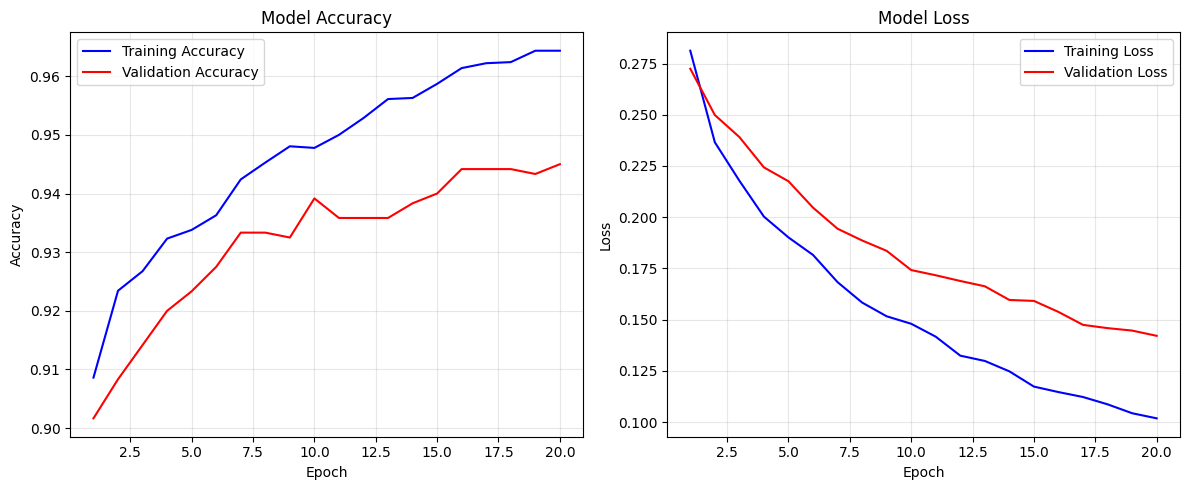


Evaluating on Test Set...
Final Test Accuracy: 0.9513


<Figure size 1000x800 with 0 Axes>

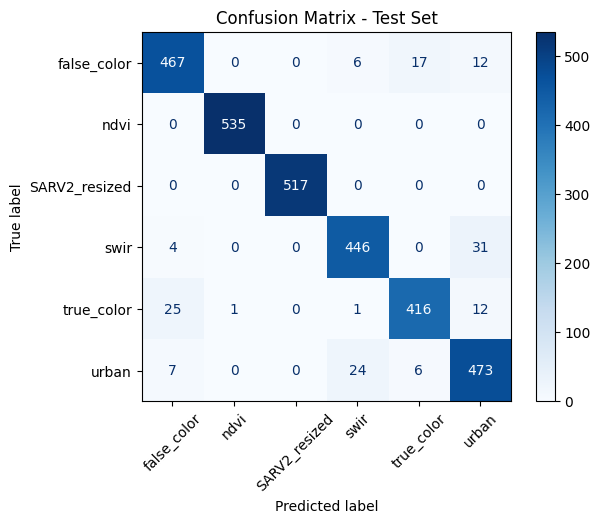


DETAILED CLASSIFICATION REPORT
               precision    recall  f1-score   support

  false_color       0.93      0.93      0.93       502
         ndvi       1.00      1.00      1.00       535
SARV2_resized       1.00      1.00      1.00       517
         swir       0.94      0.93      0.93       481
   true_color       0.95      0.91      0.93       455
        urban       0.90      0.93      0.91       510

     accuracy                           0.95      3000
    macro avg       0.95      0.95      0.95      3000
 weighted avg       0.95      0.95      0.95      3000


PER-CLASS ACCURACY
false_color: 0.9303 (467/502 correct)
ndvi: 1.0000 (535/535 correct)
SARV2_resized: 1.0000 (517/517 correct)
swir: 0.9272 (446/481 correct)
true_color: 0.9143 (416/455 correct)
urban: 0.9275 (473/510 correct)

SAMPLE PREDICTIONS (First 20 Test Samples)
✓ Sample 0: Predicted=SARV2_resized (conf: 0.9987), Actual=SARV2_resized
✓ Sample 1: Predicted=ndvi (conf: 0.9916), Actual=ndvi
✓ Sample 2: Pr

In [ ]:
### VISUALIZATION ###
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import torch

# 1. Plot Training History
def plot_training_history(history):
    """Plot training and validation metrics"""
    # Handle our PyTorch HistoryStub structure
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300)
    plt.show()

# Only plot if history is not empty
if len(history.history['accuracy']) > 0:
    plot_training_history(history)
else:
    print("No training history to plot (model loaded from checkpoint or training skipped).")

# 2. Evaluate on Test Set
print("\nEvaluating on Test Set...")
model.eval()
all_preds = []
all_probs = []
all_labels = []

# Ensure we use the best weights for evaluation
# (They were already loaded at the end of Cell 9)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)

        # Probabilities
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_probs.append(probs.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.numpy())

# Concatenate batches
y_pred_probs = np.concatenate(all_probs)
y_pred = np.concatenate(all_preds)
y_test_numpy = np.concatenate(all_labels)

# Calculate Accuracy
test_accuracy = np.mean(y_pred == y_test_numpy)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# 3. Confusion Matrix
class_names = class_dirs # From Cell 4
cm = confusion_matrix(y_test_numpy, y_pred)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d', xticks_rotation=45)
plt.title('Confusion Matrix - Test Set')
plt.show()

# 4. Classification Report
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test_numpy, y_pred, target_names=class_names))

# 5. Per-Class Accuracy
print("\n" + "="*60)
print("PER-CLASS ACCURACY")
print("="*60)
for i, class_name in enumerate(class_names):
    class_mask = y_test_numpy == i
    if class_mask.sum() > 0:
        class_accuracy = (y_pred[class_mask] == i).sum() / class_mask.sum()
        print(f"{class_name}: {class_accuracy:.4f} ({(y_pred[class_mask] == i).sum()}/{class_mask.sum()} correct)")

# 6. Sample Predictions
print("\n" + "="*60)
print("SAMPLE PREDICTIONS (First 20 Test Samples)")
print("="*60)
for i in range(min(20, len(y_test_numpy))):
    true_class = class_names[y_test_numpy[i]]
    pred_class = class_names[y_pred[i]]
    confidence = y_pred_probs[i][y_pred[i]]
    status = "✓" if y_test_numpy[i] == y_pred[i] else "✗"
    print(f"{status} Sample {i}: Predicted={pred_class} (conf: {confidence:.4f}), Actual={true_class}")